In [1]:
from gensim.models.word2vec import Word2Vec
from gensim import corpora, models, similarities
import gensim, logging
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
import numpy as np
import csv
import sklearn as sc
import os
import json
from bs4 import BeautifulSoup
import re

% matplotlib inline

In [2]:
data_dir = '/Users/christopherallison/Documents/Coding/Data'
home_dir = '/Users/christopherallison/.virtualenvs/py_twi/streaming_results'

Practicing from: https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis

In [3]:
# Read data from twitter sentiment data file

train = {}

with open(os.path.join(data_dir, 'sentiment_tweets_dataset.csv')) as f:
    
    reader = csv.reader(f)
    next(reader)
    
    for i, row in enumerate(reader):
        identity, sentiment, source, text, *extra = row
        categories = 'positive negative'.split()
        train[i] = {'target':sentiment, 'data':text, 'words': [], 'target_names': categories[int(sentiment)]}
    
    


In [4]:
data = pd.DataFrame.from_dict(train, orient='index')

In [5]:
data.head()

,target,target_names,data,words
0,0,positive,is so sad for my APL frie...,[]
1,0,positive,I missed the New Moon trail...,[]
2,1,negative,omg its already 7:30 :O,[]
3,0,positive,.. Omgaga. Im sooo im gunna CRy. I'...,[]
4,0,positive,i think mi bf is cheating on me!!! ...,[]


In [6]:
def tweet_to_wordlist(tweet, remove_stopwords=False):
    #tweet_text = BeautifulSoup(tweet).get_text()
    #tweet_text = re.sub("[^a-zA-Z]", " ", tweet)
    words = tweet.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.tweet("english"))
        words = [w for wo in words if not w in stops]
        
    return words

In [7]:
data.words = [tweet_to_wordlist(tweet) for tweet in data.data]

In [8]:
for t in data[:10]:
    print(data.target_names)

0          positive
1          positive
2          negative
3          positive
4          positive
5          positive
6          negative
7          positive
8          negative
9          negative
10         positive
11         negative
12         positive
13         positive
14         positive
15         positive
16         positive
17         negative
18         positive
19         positive
20         positive
21         positive
22         negative
23         positive
24         positive
25         positive
26         positive
27         positive
28         negative
29         positive
             ...   
1578584    negative
1578585    negative
1578586    positive
1578587    negative
1578588    positive
1578589    positive
1578590    positive
1578591    negative
1578592    negative
1578593    negative
1578594    negative
1578595    negative
1578596    positive
1578597    positive
1578598    negative
1578599    negative
1578600    negative
1578601    positive
1578602    negative


In [9]:
tweets = data.words
tweets[:10]

0     [is, so, sad, for, my, apl, friend.............]
1              [i, missed, the, new, moon, trailer...]
2                        [omg, its, already, 7:30, :o]
3    [.., omgaga., im, sooo, im, gunna, cry., i've,...
4     [i, think, mi, bf, is, cheating, on, me!!!, t_t]
5                     [or, i, just, worry, too, much?]
6                [juuuuuuuuuuuuuuuuussssst, chillin!!]
7     [sunny, again, work, tomorrow, :-|, tv, tonight]
8    [handed, in, my, uniform, today, ., i, miss, y...
9    [hmmmm...., i, wonder, how, she, my, number, @-)]
Name: words, dtype: object

In [10]:
targets = np.array(data.target)
targets[:10]

array(['0', '0', '1', '0', '0', '0', '1', '0', '1', '1'], dtype=object)

In [11]:
categories = "negative positive".split()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [15]:
vectors = vectorizer.fit_transform(data.data)
vectors.shape

(1578614, 685486)

In [16]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data.data, targets, test_size=0.2)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(x_train)
X_train_counts.shape

(1262891, 590604)

In [18]:
count_vect.vocabulary_.get(u'algorithm')

50542

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tf_transformer.fit(X_train_counts)
X_train__tfidf = tf_transformer.transform(X_train_counts)
X_train__tfidf.shape

(1262891, 590604)

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

clf = MultinomialNB().fit(X_train__tfidf, y_train)

In [83]:
docs_new = ["Superman is so cool.", "I'm not sure if it was worthwhile",
           "It was pretty sucky.", "I'll never talk to him again."]
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

In [84]:
predicted = clf.predict(X_new_tfidf)

In [85]:
for doc, category in zip(docs_new, predicted):
    print('{} => {}'.format(doc, categories[int(category)]))

Superman is so cool. => positive
I'm not sure if it was worthwhile => positive
It was pretty sucky. => negative
I'll never talk to him again. => negative


In [71]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    # Simple plot based on the Iris sample CM
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Set up Pipeline for SGD Classifier

In [58]:
from sklearn.linear_model import SGDClassifier
sgd_tweet_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                          alpha=1e-3, n_iter=5,
                                          random_state=42))
                     ])

In [59]:
_ = sgd_tweet_clf.fit(x_train, y_train)

In [60]:
sgd_predicted = sgd_tweet_clf.predict(x_test)
np.mean(sgd_predicted == y_test)

0.73024771714445891

In [61]:
print(metrics.classification_report(y_test, sgd_predicted, target_names=categories))

             precision    recall  f1-score   support

   negative       0.75      0.68      0.72    157609
   positive       0.71      0.78      0.74    158114

avg / total       0.73      0.73      0.73    315723



In [78]:
sgd_cm = metrics.confusion_matrix(y_test, sgd_predicted)

/Users/christopherallison/.virtualenvs/py_twi/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



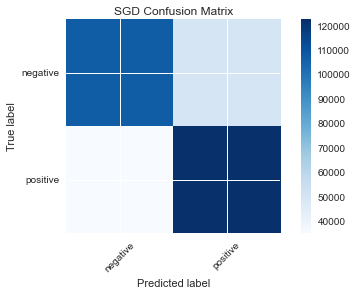

In [79]:
plot_confusion_matrix(sgd_cm, categories, title="SGD Confusion Matrix")

### Set up Pipeline for Naive Bayes Classifier

In [64]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes_tweet_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())
                     ])

In [66]:
_ = naive_bayes_tweet_clf.fit(x_train, y_train)

In [67]:
naive_bayes_predicted = naive_bayes_tweet_clf.predict(x_test)
np.mean(naive_bayes_predicted == y_test)

0.77283884924443258

In [76]:
naive_bayes_cm = metrics.confusion_matrix(y_test, naive_bayes_predicted)

In [75]:
print(cm)

[[128879  28730]
 [ 42990 115124]]


In [80]:
print(metrics.classification_report(y_test, naive_bayes_predicted, target_names=categories))

             precision    recall  f1-score   support

   negative       0.75      0.82      0.78    157609
   positive       0.80      0.73      0.76    158114

avg / total       0.78      0.77      0.77    315723



/Users/christopherallison/.virtualenvs/py_twi/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



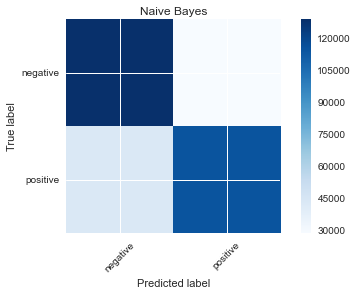

In [77]:
plot_confusion_matrix(naive_bayes_cm, categories, title='Naive Bayes')

### Testing against downloaded tweet datasets

In [88]:
def load_tweets(target):
    # Output list of tweets
    tweets = []

    with open(os.path.join(home_dir, target)) as f:
        for data in f:

            result = json.loads(data)
            
            try:
                tweets.append(result['text'])
            except KeyError:
                continue
    
    return tweets

In [89]:
def process_tweets(tweets):
    # Output processed list of tweets

    texts = [[word for word in tweet.lower().split() if word not in stopwords.words('english') and
            word not in stopwords.words('french')] for tweet in tweets]
    
    # Remove words that only occur once
    from collections import defaultdict
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    texts = [[token for token in text if frequency[token] > 1] for text in texts]

    from pprint import pprint
    #pprint(texts)
    
    return texts


In [90]:
# Download the harper tweest
harper_tweets = load_tweets('harper_stream.json')

In [97]:
# Run raw tweets through Pipeline
harper_predicted = naive_bayes_tweet_clf.predict(harper_tweets)

In [118]:
# Convert result predicted values to integers
harper_predicted = [int(z) for z in harper_predicted]

In [114]:
# Print raw tweet and predicted value
for doc, category in zip(harper_tweets, harper_predicted):
    print('{} => {}\n'.format(doc, categories[int(category)]))

RT @BD_CDA: @MrDash109 @___Danno Gopnik writes: "Stephen Harper—a charmless but effective politician". Effective? How about "charmless but … => positive

RT @JustinTrudeau: To stop Stephen Harper, we need you to vote. Find your advance polling location: http://t.co/RtSzoTP9cc http://t.co/GOfO… => positive

Vote ABC https://t.co/4kXESMVXwu => positive

@1planet_People your an idiot. Harper best prime minister in last 40 yrs.  your a regressive liberal and make no sense => positive

RT @Bollyone: Check Out @sonamakapoor @BeingSalmanKhan stunning Shoot Harper's Bazaar Bride Magazine http://t.co/rJ1nPgLD0M http://t.co/YrV… => positive

Sign! RT! I just signed this petition, please join me: http://t.co/z6nxm9lq5P via @leadnowca => positive

It's positive you agree we have a surplus in 2015. Which is what matters https://t.co/JsVkTjBbB8 => positive

RT So happy you voted! This early turnout bodes well for Canada! Can't wait to see the back of &amp; bring back our de… https://t.co/CZmUyEu6zZ 

TypeError: ufunc 'true_divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [121]:
print("Average {}".format(sum(harper_predicted) / len(harper_predicted)))

Average 0.7808988764044944


In [122]:
trudeau_tweets = load_tweets('trudeau_stream.json')
trudeau_predicted = naive_bayes_tweet_clf.predict(trudeau_tweets)

trudeau_predicted = [int(z) for z in trudeau_predicted]

print("Average {}".format(sum(trudeau_predicted) / len(trudeau_predicted)))

Average 0.7411764705882353


In [103]:
new_predicts = naive_bayes_tweet_clf.predict(docs_new)

In [104]:
for doc, category in zip(docs_new, new_predicts):
    print('{} => {}\n'.format(doc, categories[int(category)]))

Superman is so cool. => positive

I'm not sure if it was worthwhile => positive

It was pretty sucky. => negative

I'll never talk to him again. => negative



In [137]:
trial = ["Bloodborne follows the player character, the Hunter, through the fictional decrepit Gothic city of Yharnam, whose inhabitants have been afflicted with an abnormal blood-borne disease. Upon mysteriously awakening in Yharnam during the night of 'The Hunt', the Hunter seeks out something known only as 'Paleblood' for reasons unknown.[5] The Hunter begins to unravel Yharnam's intriguing mysteries while hunting down its many terrifying beasts. Eventually, the Hunter's objective is to locate and terminate the source of the plague, and escape the nightmare to return to the 'real world', known as the 'Waking World'."]

trial2 = ["The Great Depression was a severe worldwide economic depression in the 1930s. The timing of the Great Depression varied across nations; however, in most countries it started in 1929 and lasted until the late 1930s.[1] It was the longest, deepest, and most widespread depression of the 20th century.[2] Worldwide GDP fell by 15% from 1929 to 1932.[3] In the 21st century, the Great Depression is commonly used as an example of how far the world's economy can decline.[4] The depression originated in the United States, after the fall in stock prices that began around September 4, 1929, and became worldwide news with the stock market crash of October 29, 1929 (known as Black Tuesday)."]

In [138]:
trial_predicts = naive_bayes_tweet_clf.predict(trial)

trial2_predicts = naive_bayes_tweet_clf.predict(trial2)

In [140]:
print('{} => {}'.format(trial, categories[int(trial_predicts[0])]))
print("")
print('{} => {}'.format(trial2, categories[int(trial2_predicts[0])]))

["Bloodborne follows the player character, the Hunter, through the fictional decrepit Gothic city of Yharnam, whose inhabitants have been afflicted with an abnormal blood-borne disease. Upon mysteriously awakening in Yharnam during the night of 'The Hunt', the Hunter seeks out something known only as 'Paleblood' for reasons unknown.[5] The Hunter begins to unravel Yharnam's intriguing mysteries while hunting down its many terrifying beasts. Eventually, the Hunter's objective is to locate and terminate the source of the plague, and escape the nightmare to return to the 'real world', known as the 'Waking World'."] => positive

["The Great Depression was a severe worldwide economic depression in the 1930s. The timing of the Great Depression varied across nations; however, in most countries it started in 1929 and lasted until the late 1930s.[1] It was the longest, deepest, and most widespread depression of the 20th century.[2] Worldwide GDP fell by 15% from 1929 to 1932.[3] In the 21st cen

In [128]:
processed_harper_tweets = process_tweets(harper_tweets)
dictionary = corpora.Dictionary(processed_harper_tweets)

In [132]:
harper_vec = [dictionary.doc2bow(tweet) for tweet in processed_harper_tweets]

In [133]:
harper_vec

[[(0, 1), (1, 1)],
 [(0, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1)],
 [(14, 1), (15, 1)],
 [(16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1)],
 [(0, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1)],
 [(35, 1), (36, 1), (37, 1), (38, 1)],
 [(39, 1), (40, 1), (41, 1)],
 [(0, 1),
  (42, 1),
  (43, 2),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1)],
 [(26, 1), (56, 1)],
 [(0, 1),
  (26, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1)],
 [(0, 1),
  (1, 1),
  (2, 1),
  (26, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1)],
 [(0, 1),
  (26, 1),
  (39, 1),
  (75, 1),
  (76, 1),
  (77, 2),
  (78, 1),
  (79, 1),
  (80, 1),
 